In [1]:
from google.colab import drive
drive.mount ('/content/drive')

import sys
%cd /content/drive/My\ Drive/Colab\ Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis
sys.path.append('/content/drive/My Drive/Colab Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import os
import decoders
from helpers import initialize_image, gram_matrix, gram_loss, slice_loss

In [14]:
SIZE = 256
INPUT_FILE = "./input.jpg"
OUTPUT_FILE = "./output.jpg"
NB_ITER = 5

## Custom VGG model with Slicing model

Here we implement the custom vgg model which will output only specified layers from a pretrained vgg model. We also implement a seperate extractor which performs the slicing in said feature space.

In [4]:

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # A customized vgg is used as explained in the supplementals.
  vgg = keras.models.load_model('vgg_customized.h5')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

"""The loss function is implemented in class Slicing(...) and is used by ExtractorVggModel which directly returns loss """
class Slicing(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices))
        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

class ExtractorVggModel(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

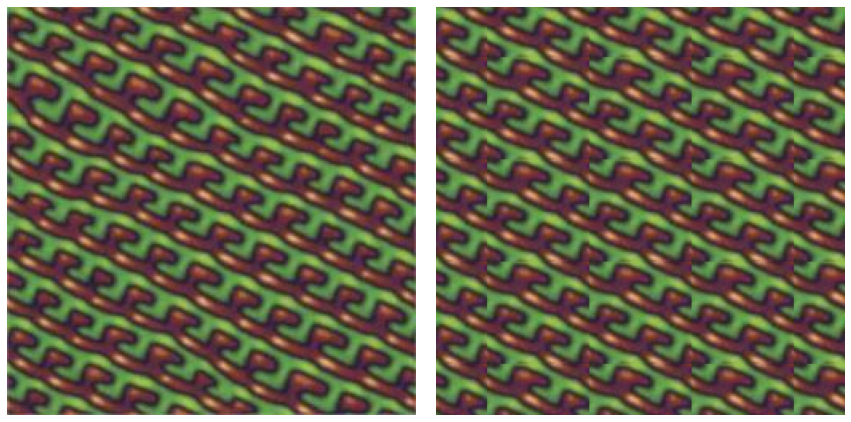

In [15]:
texture_reference_wrap = decoders.decode_image_with_patch("input.jpg", patch_size=64, target_size = SIZE)
texture_reference = decoders.decode_image("input.jpg", SIZE)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(texture_reference[0,:,:,:])
ax2.imshow(texture_reference_wrap[0,:,:,:])
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)


# VGG layers used for the loss
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1', 
          'block3_conv2',
          'block3_conv3',
          'block3_conv4',
          'block4_conv1', 
          'block4_conv2',
          'block4_conv3',
          'block4_conv4',
          'block5_conv1',
          'block5_conv2'
          ]

slice_extractor = ExtractorVggModel(layers)
vgg_layers_extractor = vgg_layers(layers)


## Texture Synthesis With Sliced Wasserstein Loss
 
In this experiment we compare the results of texture synthesis using SWD as the loss function on 1. The original input texture and 2. A patch of the input texture with wrap padding to the desired output.

iter 1 loss [0.02265614]
iter 2 loss [0.01288227]
iter 3 loss [0.00961131]
iter 4 loss [0.00812443]
iter 5 loss [0.0073569]
iter 6 loss [0.0070496]
iter 7 loss [0.0065621]
iter 8 loss [0.00630237]
iter 9 loss [0.00600876]
iter 10 loss [0.00571408]
iter 1 loss [0.04142328]
iter 2 loss [0.02807143]
iter 3 loss [0.02460149]
iter 4 loss [0.02214874]
iter 5 loss [0.0214832]
iter 6 loss [0.01993841]
iter 7 loss [0.01913597]
iter 8 loss [0.01836029]
iter 9 loss [0.01778073]
iter 10 loss [0.01734363]


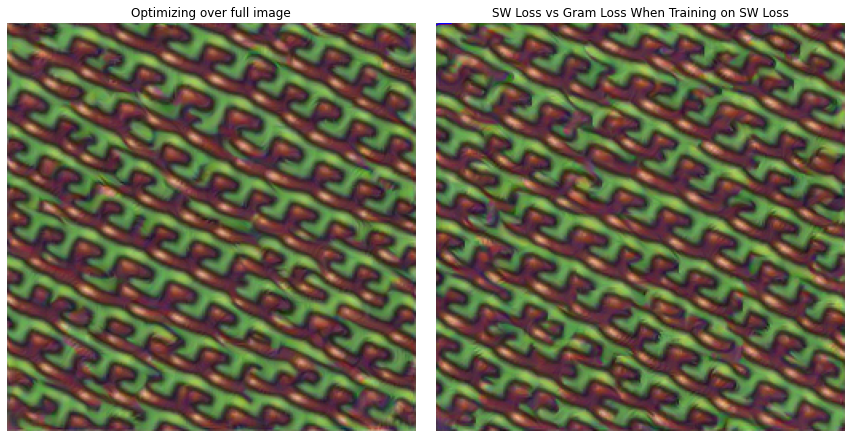

In [19]:
NB_ITER = 10
def loss_and_grad_slice(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_slice(nb_iter, texture, extractor, feature_layers = None):
    targets = extractor(texture)
    image = initialize_image(SIZE, texture)
    losses_gram = []
    losses_slice = []
    for i in range(nb_iter):
      arg_opt = {'extractor': extractor, 'targets':targets}
      image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_slice, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
      image = np.clip(image, 0, 1)
      print(f'iter {i+1} loss {loss}')
    
      # Change random directions (optional)
      extractor.update_slices()
      targets = extractor(texture)

      # compare current gram loss with sw loss
      image = np.reshape(image, (1,SIZE, SIZE, 3))
      loss1 = gram_loss(image, texture, feature_layers)
      loss2 = slice_loss(image, texture, extractor)
      losses_gram.append(loss1)
      losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

output_image,out_gram_losses,out_slice_losses = fit_slice(NB_ITER, texture_reference, slice_extractor, vgg_layers_extractor)
output_image_wrap,out_gram_losses_wrap,out_slice_losses_wrap = fit_slice(NB_ITER, texture_reference_wrap, slice_extractor, vgg_layers_extractor)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image[0,:,:,:])
ax2.imshow(output_image_wrap[0,:,:,:])
ax1.axis('off')
ax1.set_title('Optimizing over full image')
ax2.axis('off')
ax2.set_title('Optimizing over image patch wrapped')
plt.subplots_adjust(wspace=0.05, hspace=0)

### Comparing Loss when training on SWD

This experiment displays that although the synthesis was trained using SWD, the gram matrix loss also converged as a by product.

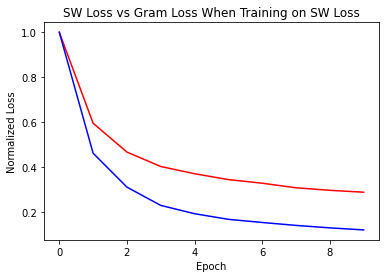

In [20]:
TS_gram_plot = np.array(out_gram_losses)
TS_slice_plot = np.array(out_slice_losses)

plt.plot(TS_slice_plot/TS_slice_plot[0],'r')
plt.plot(TS_gram_plot/TS_gram_plot[0],'b')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(np.arange(0,NB_ITER,2))
plt.title("SW Loss (red) vs Gram Loss (blue) When Training on SW Loss")
plt.show()

## Texture Synthesis With Gram Matrix Loss
 
In this experiment we compare the results of texture synthesis using Gram matrix loss as the loss function on the same two inputs as before.

iter 1 loss [0.01069714]
iter 2 loss [0.00355605]
iter 3 loss [0.00203686]
iter 4 loss [0.00140518]
iter 5 loss [0.00111103]
iter 6 loss [0.00092892]
iter 7 loss [0.0007915]
iter 8 loss [0.000695]
iter 9 loss [0.00061859]
iter 10 loss [0.00056201]
iter 1 loss [0.01298927]
iter 2 loss [0.00512004]
iter 3 loss [0.00342249]
iter 4 loss [0.00264438]
iter 5 loss [0.00225347]
iter 6 loss [0.0020212]
iter 7 loss [0.00185238]
iter 8 loss [0.00170844]
iter 9 loss [0.00157547]
iter 10 loss [0.00148057]


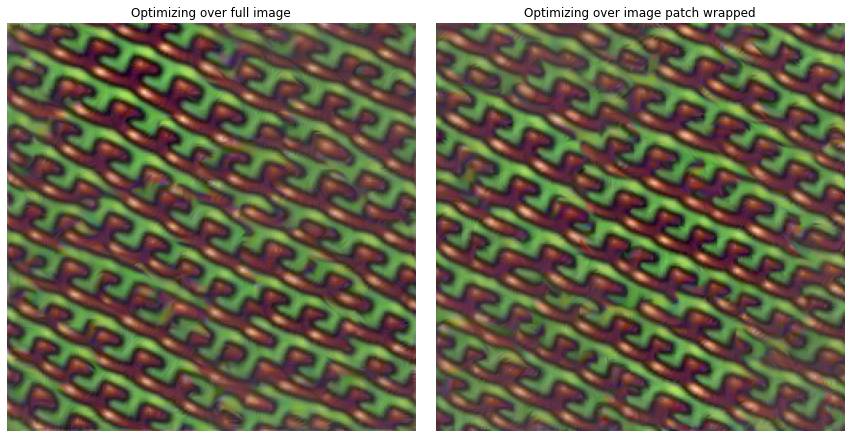

In [23]:
def loss_and_grad_gram(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    targets = args['targets']
    extractor = args['extractor']
    gram_target = [gram_matrix(feature) for feature in targets]

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        gram_image = [gram_matrix(feature) for feature in extractor(image_tf)]
        #L2 between the sorted slices (generated image vs target texture)
        loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_gram(nb_iter, texture, extractor, feature_layers):
    targets = feature_layers(texture)
    image = initialize_image(SIZE, texture)
    losses_gram = []
    losses_slice = []
    for i in range(nb_iter):
        arg_opt = {'extractor': feature_layers, 'targets':targets}

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_gram, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')

        # compare current gram loss with sw loss
        image = np.reshape(image, (1,SIZE, SIZE, 3)).astype('float32')
        loss1 = gram_loss(image, texture, feature_layers)
        loss2 = slice_loss(image, texture, extractor)
        losses_gram.append(loss1)
        losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

output_gram, out_gram_losses, out_slice_losses  = fit_gram(NB_ITER, texture_reference, slice_extractor, vgg_layers_extractor)
output_gram_wrap, out_gram_losses_wrap, out_slice_losses_wrap = fit_gram(NB_ITER, texture_reference_wrap, slice_extractor, vgg_layers_extractor)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_gram[0,:,:,:])
ax2.imshow(output_gram_wrap[0,:,:,:])
ax1.axis('off')
ax1.set_title('Optimizing over full image')
ax2.axis('off')
ax2.set_title('Optimizing over image patch wrapped')
plt.subplots_adjust(wspace=0.05, hspace=0)


### Comparing Loss when Training on Gram Matrix Loss

This experiment shows that when training on the gram matrix loss the SWD loss doesnt converge as well.

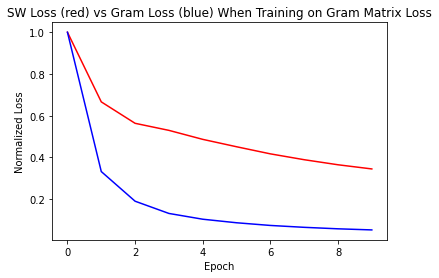

In [24]:
TS_gram_plot = np.array(out_gram_losses)
TS_slice_plot = np.array(out_slice_losses)

plt.plot(TS_slice_plot/TS_slice_plot[0],'r')
plt.plot(TS_gram_plot/TS_gram_plot[0],'b')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(np.arange(0,NB_ITER,2))
plt.title("SW Loss (red) vs Gram Loss (blue) When Training on Gram Matrix Loss")
plt.show()

## Adam Optimizer

In this experiment we test replacing the LBFGS optimzer with the adam optimizer in tensorflow.

In [36]:
extractor = vgg_layers(layers)
slice_extractor = ExtractorVggModel(layers)

optimizer = tf.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)
image = initialize_image(256, texture_reference)

def train_step_gram(image):
  with tf.GradientTape() as tape:
    loss = gram_loss(image, texture_reference, extractor)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss

def train_step_slice(image):
  with tf.GradientTape() as tape:
    loss = slice_loss(image, texture_reference, slice_extractor)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss

iter 1 loss 5.684759140014648
iter 101 loss 1.4292593002319336
iter 201 loss 0.6291419863700867
iter 301 loss 0.18128320574760437
iter 401 loss 0.10702050477266312
iter 501 loss 0.07022108137607574
iter 601 loss 0.05226186662912369
iter 701 loss 0.041905224323272705
iter 801 loss 0.03537596017122269
iter 901 loss 0.030936062335968018
iter 1001 loss 0.027655959129333496
iter 1101 loss 0.02509358339011669
iter 1201 loss 0.023000337183475494
iter 1301 loss 0.021252993494272232
iter 1401 loss 0.01976924017071724
iter 1501 loss 0.01848871447145939
iter 1601 loss 0.01736757718026638
iter 1701 loss 0.016373274847865105
iter 1801 loss 0.015479320660233498
iter 1901 loss 0.014675380662083626
iter 2001 loss 0.013947637751698494
iter 2101 loss 0.01329234428703785
iter 2201 loss 0.012704426422715187
iter 2301 loss 0.012168096378445625
iter 2401 loss 0.011681189760565758
iter 2501 loss 0.01123809814453125
iter 2601 loss 0.010834038257598877
iter 2701 loss 0.010462777689099312
iter 2801 loss 0.01011

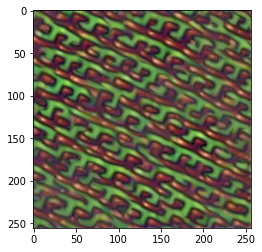

In [39]:
image_var = tf.Variable(image)
loss = []
iter = 5000
for i in range(iter):
  cur_loss = train_step_gram(image_var)
  loss.append(cur_loss)
  if i % 100 is 0:
    print(f'iter {i+1} loss {cur_loss}')

plt.imshow(image_var[0,:,:,:])

iter 1 loss 12.171310424804688
iter 101 loss 1.3042058944702148
iter 201 loss 0.6595216989517212
iter 301 loss 0.26492568850517273
iter 401 loss 0.15425804257392883
iter 501 loss 0.10554008185863495
iter 601 loss 0.08208374679088593
iter 701 loss 0.06795430183410645
iter 801 loss 0.05900665745139122
iter 901 loss 0.05269083380699158
iter 1001 loss 0.04800386726856232
iter 1101 loss 0.04435344040393829
iter 1201 loss 0.04139861837029457
iter 1301 loss 0.03892818093299866
iter 1401 loss 0.03683096915483475
iter 1501 loss 0.035024214535951614
iter 1601 loss 0.03344659507274628
iter 1701 loss 0.032037701457738876
iter 1801 loss 0.030767768621444702
iter 1901 loss 0.02963343635201454
iter 2001 loss 0.02861109934747219
iter 2101 loss 0.02766958624124527
iter 2201 loss 0.02679837867617607
iter 2301 loss 0.02598884142935276
iter 2401 loss 0.025229256600141525
iter 2501 loss 0.02451559156179428
iter 2601 loss 0.023848790675401688
iter 2701 loss 0.02322852611541748
iter 2801 loss 0.0226529128849

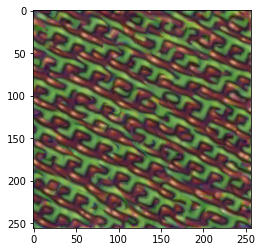

In [40]:
image_var = tf.Variable(image)
loss = []
iter = 5000
for i in range(iter):
  cur_loss = train_step_slice(image_var)
  loss.append(cur_loss)
  if i % 100 is 0:
    print(f'iter {i+1} loss {cur_loss}')

plt.imshow(image_var[0,:,:,:])